In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Folder "nr_128_64" consist of CT scans having normal lung tissue or other lung disease

normal_scan_paths = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE1117/nr_128_64", x)
    for x in os.listdir("C:/Users/85298/AI/PE1117/nr_128_64")
]
# Folder "pe_128_64" consist of CT scans having Pulmonary embolism,

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE1117/pe_128_64", x)
    for x in os.listdir("C:/Users/85298/AI/PE1117/pe_128_64")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 187
CT scans with abnormal lung tissue: 72


In [3]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

In [4]:
import time
start = time.time()

abnormal_scans = np.array([read_nifti_file(path) for path in abnormal_scan_paths])
normal_scans = np.array([read_nifti_file(path) for path in normal_scan_paths])



# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
#abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
#normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

end = time.time()
print(end-start)



2.432100772857666


In [5]:
# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:50], normal_scans[:131]), axis=0)
y_train = np.concatenate((abnormal_labels[:50], normal_labels[:131]), axis=0)
x_val = np.concatenate((abnormal_scans[50:], normal_scans[131:]), axis=0)
y_val = np.concatenate((abnormal_labels[50:], normal_labels[131:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 181 and 78.


In [6]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume


    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float64)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0', '/device:GPU:1']

In [8]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [9]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [10]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
91/91 - 18s - loss: 0.6501 - acc: 0.6519 - val_loss: 0.6878 - val_acc: 0.7179 - 18s/epoch - 203ms/step
Epoch 2/100
91/91 - 14s - loss: 0.6115 - acc: 0.6961 - val_loss: 0.5981 - val_acc: 0.7179 - 14s/epoch - 157ms/step
Epoch 3/100
91/91 - 15s - loss: 0.6108 - acc: 0.7127 - val_loss: 0.7074 - val_acc: 0.3462 - 15s/epoch - 160ms/step
Epoch 4/100
91/91 - 14s - loss: 0.5938 - acc: 0.6851 - val_loss: 1.1690 - val_acc: 0.2821 - 14s/epoch - 156ms/step
Epoch 5/100
91/91 - 14s - loss: 0.5624 - acc: 0.7514 - val_loss: 0.7754 - val_acc: 0.4103 - 14s/epoch - 157ms/step
Epoch 6/100
91/91 - 14s - loss: 0.5666 - acc: 0.7127 - val_loss: 0.6834 - val_acc: 0.5256 - 14s/epoch - 157ms/step
Epoch 7/100
91/91 - 14s - loss: 0.5866 - acc: 0.7238 - val_loss: 0.9540 - val_acc: 0.3205 - 14s/epoch - 156ms/step
Epoch 8/100
91/91 - 14s - loss: 0.5832 - acc: 0.7238 - val_loss: 0.5601 - val_acc: 0.7051 - 14s/epoch - 157ms/step
Epoch 9/100
91/91 - 14s - loss: 0.5625 - acc: 0.7238 - val_loss: 0.6474 - val_ac

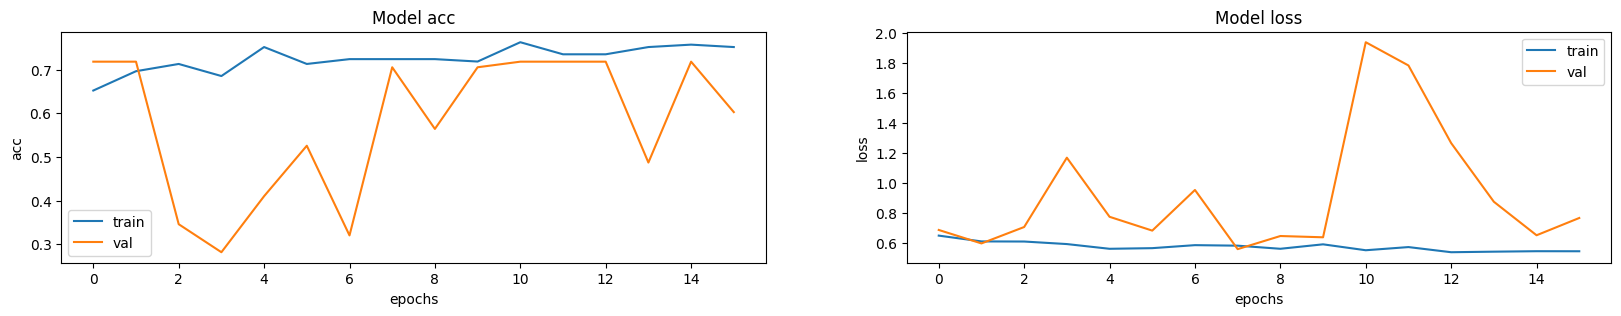

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
abnormal_correct = 0
abnormal_wrong = 0
other_correct = 0
other_wrong = 0
for patient in range (0,len(y_val)):
    

# Load best weights.

    model.load_weights("3d_image_classification.h5")
    prediction = model.predict(np.expand_dims(x_val[patient], axis=0))[0]
    label_1 = y_val[patient]
    
    scores = [1 - prediction[0], prediction[0]]
    print(label_1)
    if (prediction[0] > 0.4) & (label_1 == 1) :
        abnormal_correct = abnormal_correct + 1
    if (prediction[0] > 0.4) & (label_1 == 0) :
        abnormal_wrong = abnormal_wrong + 1
    if (prediction[0] < 0.4) & (label_1 == 0) :
        other_correct = other_correct + 1
    if (prediction[0] < 0.4) & (label_1 == 1) :
        other_wrong = other_wrong + 1        
        
        
    
        
    print (abnormal_correct,other_wrong,other_correct,abnormal_wrong )    
        

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
        
#        print (prediction[0])

1/1 [==============================] - 0s 18ms/step
1
0 1 0 0
This model is 73.94 percent confident that CT scan is normal
This model is 26.06 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 17ms/step
1
1 1 0 0
This model is 58.44 percent confident that CT scan is normal
This model is 41.56 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 18ms/step
1
1 2 0 0
This model is 67.95 percent confident that CT scan is normal
This model is 32.05 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 16ms/step
1
1 3 0 0
This model is 76.92 percent confident that CT scan is normal
This model is 23.08 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 15ms/step
1
1 4 0 0
This model is 62.17 percent confident that CT scan is normal
This model is 37.83 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 17ms/step
1
1 5 0 0
This mod

1/1 [==============================] - 0s 14ms/step
0
8 14 19 4
This model is 88.40 percent confident that CT scan is normal
This model is 11.60 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 14ms/step
0
8 14 20 4
This model is 75.26 percent confident that CT scan is normal
This model is 24.74 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 14ms/step
0
8 14 21 4
This model is 76.55 percent confident that CT scan is normal
This model is 23.45 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 14ms/step
0
8 14 22 4
This model is 84.41 percent confident that CT scan is normal
This model is 15.59 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 14ms/step
0
8 14 23 4
This model is 68.35 percent confident that CT scan is normal
This model is 31.65 percent confident that CT scan is abnormal
1/1 [==============================] - 0s 15ms/step
0
8 14 2

Text(0.5, 192.72222222222217, 'Predicted')

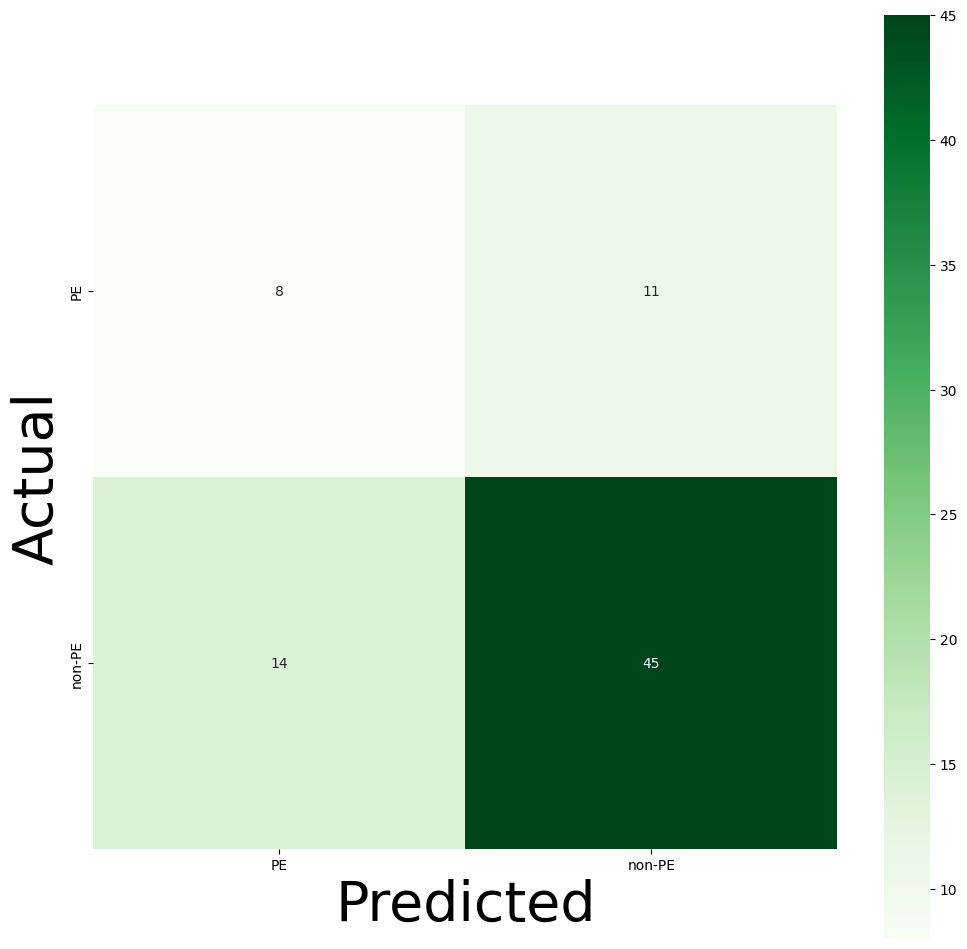

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Y_pred = model.predict(x_val)
disease_types=['PE', 'non-PE']



#Y_pred = np.argmax(Y_pred, axis=1)
#Y_true = y_val
#Y_true = np.argmax(y_val,axis=1)
#print (Y_pred)
#print (Y_true)
#cm = confusion_matrix(Y_true, Y_pred)

cm = [[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [21]:
[[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

TP = abnormal_correct
FP = abnormal_wrong
TN = other_correct
FN = other_wrong

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

F1_score = ((Precision*Recall)/(Precision+Recall))*2

Accuracy = (TP+TN)/(TP+FP+TN+FN)

print ("Precision",Precision)
print ("Recall",Recall)
print ("F1_score",F1_score)
print ("Accuracy",Accuracy)

Precision 0.42105263157894735
Recall 0.36363636363636365
F1_score 0.3902439024390244
Accuracy 0.6794871794871795
